# Projeto 3 - Ciência dos Dados

Nome: Lara Christine Melo Vasconcelos

Nome: João Lucas Brasileiro

Nome: Yamandú Germano

Nome: Silas André Pereira

Nome: Enzo Christofoletti

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import randint

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## Primeiro `Modelo Logístico` com o banco de dados

In [2]:
dados = pd.read_csv('dados_filtrados.csv',sep=';').dropna()
dados.head(5)

,vacina_descricao_dose,paciente_idade,paciente_racaCor_valor,paciente_endereco_uf,vacina_categoria_nome,paciente_enumSexoBiologico
0,1ª Dose,38.0,AMARELA,SP,Faixa Etária,M
1,3ª Dose,5.0,BRANCA,RS,Faixa Etária,M
2,1ª Dose,48.0,SEM INFORMACAO,SP,Faixa Etária,M
3,1ª Dose,77.0,SEM INFORMACAO,MG,Faixa Etária,F
4,Reforço,63.0,SEM INFORMACAO,SP,Faixa Etária,M


**Definindo os tipos dos dados**

In [3]:
dados = dados.astype({
    'vacina_descricao_dose' : 'category',
    'paciente_idade' : 'int8',
    'paciente_racaCor_valor' : 'category',
    'paciente_endereco_uf' : 'category',
    'vacina_categoria_nome' : 'category',
    'paciente_enumSexoBiologico' : 'category'
})

**Padronização dos dados da coluna `paciente_idade`**

Esse passo é necessário para aumentar a acurácia do modelo pois distribui os dados em um range de média 0 e desvio padrão e 1.

In [4]:
scaler = StandardScaler()
scaler_fit = scaler.fit_transform(dados['paciente_idade'].to_frame())

**Converter variáveis categóricas em variáveis booleanas**

Assim, é possível utiliza-las no modelo de Regressão Logística.
A função `get_dummies()` retorna um dataframe para cada categoria onde as células são valores booleanos

In [5]:
uf = pd.get_dummies(dados["paciente_endereco_uf"],drop_first=True).reset_index(drop=True)
sexobio = pd.get_dummies(dados["paciente_enumSexoBiologico"],drop_first=True).reset_index(drop=True)
cor = pd.get_dummies(dados["paciente_racaCor_valor"],drop_first=True).reset_index(drop=True)
categoria = pd.get_dummies(dados["vacina_categoria_nome"],drop_first=True).reset_index(drop=True)

FeaturesProcessadas = pd.concat([
    pd.Series(scaler_fit.flatten()),
    uf,
    sexobio,
    cor,
    categoria
    ], axis=1)

FeaturesProcessadas.columns = FeaturesProcessadas.columns.astype(str)


TargetProcessado = dados["vacina_descricao_dose"].reset_index(drop=True)

**Separando o banco de dados entre `train` e `test`**

In [6]:
randomState = randint(0,100000)
x_train,x_test = train_test_split(FeaturesProcessadas, test_size=.3 , train_size=.7 , shuffle=True, random_state=randomState)
y_train,y_test = train_test_split(TargetProcessado, test_size=.3 , train_size=.7 , shuffle=True, random_state=randomState)


**Aplicando o banco de `train` no modelo**

In [54]:
model = LogisticRegression(class_weight='balanced')
model.fit(x_train,y_train)

c:\Users\yaman\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

**Resultados do Modelo**

In [55]:
testsResult = model.predict(x_test)
print(classification_report(y_test,testsResult))

              precision    recall  f1-score   support

     1ª Dose       0.63      0.39      0.48    184440
     2ª Dose       0.39      0.32      0.35    110745
     3ª Dose       0.02      0.47      0.04      2597
     4ª Dose       0.03      0.53      0.05       662
     5ª Dose       0.00      0.76      0.00        29

    accuracy                           0.36    298473
   macro avg       0.21      0.49      0.18    298473
weighted avg       0.53      0.36      0.43    298473



<Axes: >

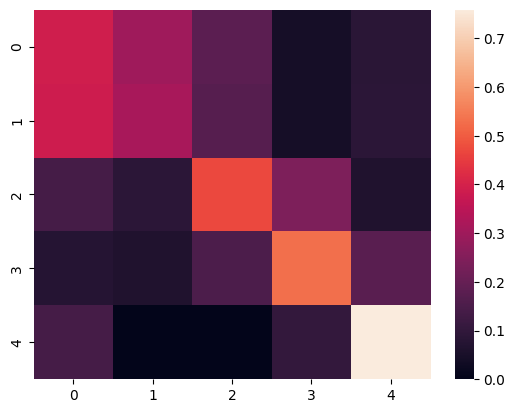

In [56]:
sns.heatmap(confusion_matrix(y_test,testsResult,normalize='true'))

## Simplificando o banco de dados

Dado que a coluna `target` possui muitas categorias distintas (19 opções de descrição para a dose da vacina), o modelo tem dificuldade em prever o caso em que o paciente tomou a `3ª dose`.
Para melhorar a quantidade de dados disponíveis, essa coluna irá ser simplificada em rótulos.

In [10]:
display(pd.Series(dados['vacina_descricao_dose'].unique()).to_frame())

,0
0,1ª Dose
1,3ª Dose
2,Reforço
3,2ª Dose
4,Única
5,2º Reforço
6,Dose
7,Revacinação
8,Dose Adicional
9,1º Reforço


A simplificação será feita da seguinte maneira:

1ª Dose : `1ª Dose Revacinação`, `1ª Dose Dobrada`, `1º Reforço`, `Única`, `Reforço`, `Dose` e `Revacinação`\
2ª Dose: `2º Reforço`, `2ª Dose Revacinação`, `Dose Adicional`\
3ª Dose: `3º Reforço` e `3ª Dose Revacinação`\
4ª Dose: `4º Reforço` e `4ª Dose Revacinação`\
5ª Dose: `5ª Dose Revacinação`



In [39]:
TargetProcessado2 = dados["vacina_descricao_dose"].astype('string')

TargetProcessado2.loc[TargetProcessado2.isin(["1ª Dose Revacinação","1ª Dose Dobrada","1º Reforço","Única","Reforço","Dose","Revacinação"])] = "1ª Dose"
TargetProcessado2.loc[TargetProcessado2.isin(["2º Reforço","2ª Dose Revacinação","Dose Adicional"])] = "2ª Dose"
TargetProcessado2.loc[TargetProcessado2.isin(["3º Reforço","3ª Dose Revacinação"])] = "3ª Dose"
TargetProcessado2.loc[TargetProcessado2.isin(["4º Reforço","4ª Dose Revacinação"])] = "4ª Dose"
TargetProcessado2.loc[TargetProcessado2.isin(["5ª Dose Revacinação"])] = "5ª Dose"

TargetProcessado2 = TargetProcessado2.astype('category')

In [40]:
(TargetProcessado2.value_counts(normalize=True)*100).round(2)

vacina_descricao_dose
1ª Dose    61.81
2ª Dose    37.10
3ª Dose     0.87
4ª Dose     0.22
5ª Dose     0.01
Name: proportion, dtype: float64

**Separando a nova coluna `Target` entre `train` e `test`**

In [41]:
y_train,y_test = train_test_split(TargetProcessado2, test_size=.3 , train_size=.7 , shuffle=True, random_state=randomState)

**Aplicando o novo `Target` ao modelo**

In [60]:
model = LogisticRegression(solver="sag",class_weight='balanced')
model.fit(x_train,y_train)

**Resultados do modelo**

In [58]:
testsResult = model.predict(x_test)
print(classification_report(y_test,testsResult))

              precision    recall  f1-score   support

     1ª Dose       0.62      0.87      0.73    184440
     2ª Dose       0.45      0.01      0.01    110745
     3ª Dose       0.04      0.27      0.08      2597
     4ª Dose       0.04      0.49      0.08       662
     5ª Dose       0.00      0.69      0.00        29

    accuracy                           0.54    298473
   macro avg       0.23      0.47      0.18    298473
weighted avg       0.55      0.54      0.45    298473



<Axes: >

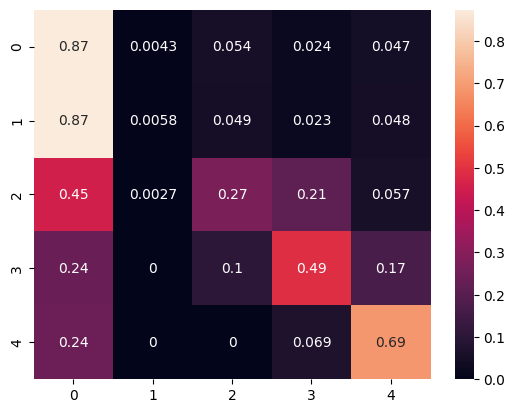

In [59]:
sns.heatmap(confusion_matrix(y_test,testsResult,normalize='true'),annot=True)

## Simplificando ainda mais a coluna `Target`

Agora, a coluna foi definida entre os valores `True` e `False` para se o paciente tomou a partir da 2ª dose da vacina.

In [17]:
TargetProcessado3 = TargetProcessado2.isin(["2ª Dose","3ª Dose","4ª Dose","5ª Dose"])
print(TargetProcessado3.value_counts(normalize=True))

vacina_descricao_dose
False    0.618053
True     0.381947
Name: proportion, dtype: float64


In [18]:
y_train,y_test = train_test_split(TargetProcessado3, test_size=.3 , train_size=.7 , shuffle=True, random_state=randomState)

In [19]:
model = LogisticRegression()
model.fit(x_train,y_train)

LogisticRegression()

In [20]:
testsResult = model.predict(x_test)
print(classification_report(y_test,testsResult))

              precision    recall  f1-score   support

       False       0.62      1.00      0.76    184440
        True       0.54      0.00      0.00    114033

    accuracy                           0.62    298473
   macro avg       0.58      0.50      0.38    298473
weighted avg       0.59      0.62      0.47    298473



<Axes: >

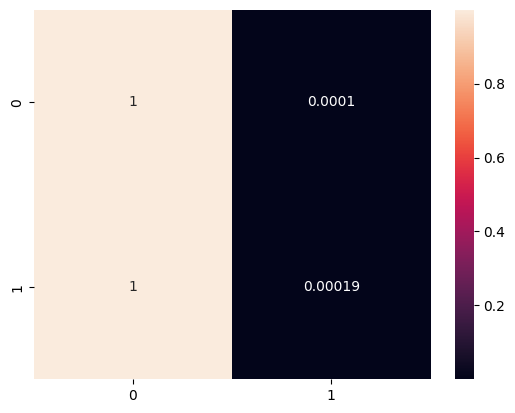

In [21]:
sns.heatmap(confusion_matrix(y_test,testsResult,normalize='true'),annot=True)